In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import itertools
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import sqrt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from math import sqrt
from numpy import array
from numpy import split
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.regularizers import L1L2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

Using TensorFlow backend.


In [3]:
dailyData = pd.read_csv('../../dataset/dailyData.csv', low_memory=False, infer_datetime_format=True, index_col=['DateTime'], header=0, parse_dates=['DateTime'])
weeklyData = pd.read_csv('../../dataset/weeklyData.csv', low_memory=False, infer_datetime_format=True, index_col=['DateTime'], header=0, parse_dates=['DateTime'])
monthlyData = pd.read_csv('../../dataset/monthlyData.csv', low_memory=False, infer_datetime_format=True, index_col=['DateTime'], header=0, parse_dates=['DateTime'])

In [4]:
values = dailyData.values # taking global active power
print(values)
dailyData['Sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])
print(dailyData.head())

[[1.2091760e+03 3.4922000e+01 9.3552530e+04 ... 0.0000000e+00
  5.4600000e+02 4.9260000e+03]
 [3.3904600e+03 2.2600600e+02 3.4572532e+05 ... 2.0330000e+03
  4.1870000e+03 1.3341000e+04]
 [2.2038260e+03 1.6179200e+02 3.4737364e+05 ... 1.0630000e+03
  2.6210000e+03 1.4018000e+04]
 ...
 [1.7962480e+03 1.3246000e+02 3.4564459e+05 ... 1.0960000e+03
  2.8480000e+03 1.2224000e+04]
 [1.4311640e+03 1.1612800e+02 3.4781221e+05 ... 1.0760000e+03
  4.2600000e+02 5.0720000e+03]
 [1.4881040e+03 1.2082600e+02 3.0348757e+05 ... 1.0800000e+03
  3.8500000e+02 9.9890000e+03]]
            Global_active_power  Global_reactive_power    Voltage  \
DateTime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20            

In [5]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [6]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train = data['2006-12-17':'2010-01-02']
    train = train.values
    test = data['2010-01-03':'2010-11-20']
    test = test.values
    # train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

In [7]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
# calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [8]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [24]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

In [10]:
# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features), bias_regularizer=L1L2(l1=0.01, l2=0.01)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [11]:
# train the CNN model
def build_model_cnn(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True, bias_regularizer=L1L2(l1=0.01, l2=0.01)))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [12]:
# train the CONV model
def build_model_conv(train, n_steps, n_length, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape into subsequences [samples, time steps, rows, cols, channels]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features), bias_regularizer=L1L2(l1=0.01, l2=0.01)))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [13]:
# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [14]:
# make a forecast
def forecast_conv(model, history, n_steps, n_length, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [samples, time steps, rows, cols, channels]
    input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [15]:
# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores, predictions

In [16]:
# evaluate CNN_LSTM model
def evaluate_model_cnn(train, test, n_input):
    # fit model
    model = build_model_cnn(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores, predictions

In [17]:
# evaluate CONV_LSTM model
def evaluate_model_conv(train, test, n_steps, n_length, n_input):
    # fit model
    model = build_model_cnn(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast_conv(model, history, n_steps, n_length, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores, predictions

(159, 7, 8)
3390.46 1311.8059999999996
(46, 7, 8)
2083.4539999999993 2197.006000000004
159
46
46
lstm: [453.585] 404.2, 546.0, 517.8, 434.5, 396.8, 323.5, 509.6
lstm_cnn: [433.381] 408.1, 525.7, 460.3, 410.4, 382.7, 323.8, 490.0


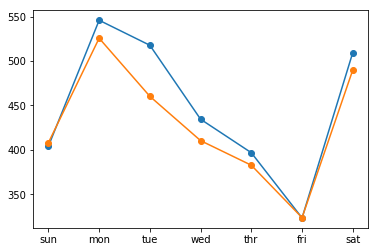

In [21]:
train, test = split_dataset(dailyData)
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])
n_input = 14
# define the number of subsequences and the length of subsequences
n_steps, n_length = 2, 7
score, scores, predictions = evaluate_model(train, test, n_input)
score_cnn, scores_cnn, predictions_cnn = evaluate_model_cnn(train, test, n_input)
#score_conv, scores_conv, predictions_conv = evaluate_model_conv(train, test, n_steps, n_length, n_input)
#print(predictions)
print(len(train))
print(len(test))
print(len(predictions))

# summarize scores
summarize_scores('lstm', score, scores)
summarize_scores('lstm_cnn', score_cnn, scores_cnn)
#summarize_scores('lstm_conv', score_conv, scores_conv)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.plot(days, scores_cnn, marker='o', label='lstm_cnn')
#pyplot.plot(days, scores_conv, marker='o', label='lstm_conv')
pyplot.show()

(46, 7)
322
322
322


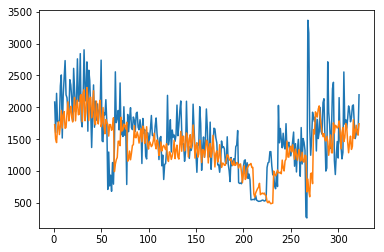

In [22]:
print(predictions.shape)
x_values = []
y_values = []
for i in range(len(test)):
    for j in range(7):
        x_values.append(test[i, j, 0])
        y_values.append(predictions[i, j])
print(len(x_values))
print(len(y_values))
print(len(residuals))
pyplot.plot(range(1,323), x_values, label = 'actual')
pyplot.plot(range(1,323), y_values, label = 'predicted')
pyplot.show()

# Hybrid Model Starts

c:\users\mimos\anaconda3\envs\tf_cpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1320      0.032     -4.125      0.000      -0.195      -0.069
ar.L2         -0.7979      0.039    -20.693      0.000      -0.873      -0.722
ar.L3          0.3345      0.035      9.689      0.000       0.267       0.402
ar.L4          0.0418      0.034      1.215      0.224      -0.026       0.109
ma.L1         -0.4545      0.021    -21.500      0.000      -0.496      -0.413
ma.L2          0.5349      0.022     24.014      0.000       0.491       0.579
ma.L3         -0.8665      0.022    -40.300      0.000      -0.909      -0.824
ar.S.L7        0.0921      0.031      3.000      0.003       0.032       0.152
ar.S.L14       0.0290      0.028      1.054      0.292      -0.025       0.083
sigma2      1.965e+05   6849.771     28.682      0.000    1.83e+05     2.1e+05
1113
3390.46
ARIMA[4, 1, 3]x[2, 0, 0, 7] - AIC:16357

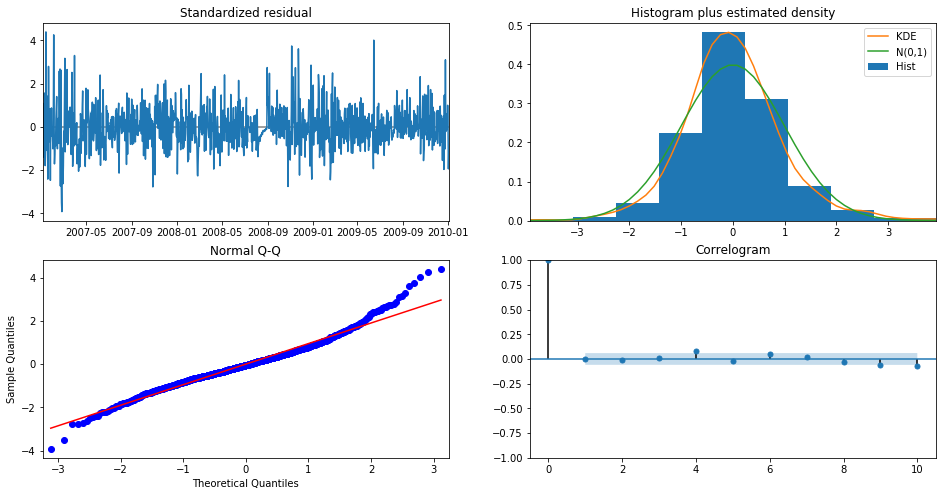

In [66]:
param_seasonal = [2,0,0,7]
pdq = [4,1,3]

dailyGAP = dailyData['Global_active_power']
dailyGAP_train = dailyGAP['2006-12-17':'2010-01-02']

mod = sm.tsa.statespace.SARIMAX(dailyGAP_train,
                                order = pdq,
                                seasonal_order= param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)


results = mod.fit()
print(results.summary().tables[1])
rmse = sqrt(mean_squared_error(results.fittedvalues, dailyGAP_train))
residuals = dailyGAP_train - results.fittedvalues
print(len(residuals))
print(residuals[0])
print('ARIMA{}x{} - AIC:{} -RMSE:{}'.format(pdq, param_seasonal, results.aic, rmse))
results.plot_diagnostics(figsize=(16,8))
plt.show()

In [29]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

In [72]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [75]:
scaler = MinMaxScaler(feature_range=(0, 1))
residuals = pd.DataFrame(data_raw)
scaled = scaler.fit_transform(residuals)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
print(reframed.head())
print(len(reframed))

   var1(t-1)   var1(t)
1   1.000000  0.163924
2   0.163924  0.469684
3   0.469684  0.185519
4   0.185519  0.183703
5   0.183703  0.595455
1112


c:\users\mimos\anaconda3\envs\tf_cpu\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(1084, 1, 1) (1084,) (28, 1, 1) (28,)
Train on 1084 samples, validate on 28 samples
Epoch 1/20
 - 4s - loss: 0.1016 - val_loss: 0.0731
Epoch 2/20
 - 0s - loss: 0.0541 - val_loss: 0.0342
Epoch 3/20
 - 0s - loss: 0.0227 - val_loss: 0.0135
Epoch 4/20
 - 0s - loss: 0.0100 - val_loss: 0.0092
Epoch 5/20
 - 0s - loss: 0.0087 - val_loss: 0.0094
Epoch 6/20
 - 0s - loss: 0.0087 - val_loss: 0.0092
Epoch 7/20
 - 0s - loss: 0.0086 - val_loss: 0.0091
Epoch 8/20
 - 0s - loss: 0.0085 - val_loss: 0.0091
Epoch 9/20
 - 0s - loss: 0.0082 - val_loss: 0.0090
Epoch 10/20
 - 0s - loss: 0.0086 - val_loss: 0.0090
Epoch 11/20
 - 0s - loss: 0.0084 - val_loss: 0.0089
Epoch 12/20
 - 0s - loss: 0.0084 - val_loss: 0.0089
Epoch 13/20
 - 0s - loss: 0.0083 - val_loss: 0.0089
Epoch 14/20
 - 0s - loss: 0.0083 - val_loss: 0.0088
Epoch 15/20
 - 0s - loss: 0.0082 - val_loss: 0.0088
Epoch 16/20
 - 0s - loss: 0.0082 - val_loss: 0.0087
Epoch 17/20
 - 0s - loss: 0.0082 - val_loss: 0.0087
Epoch 18/20
 - 0s - loss: 0.0082 - val_lo

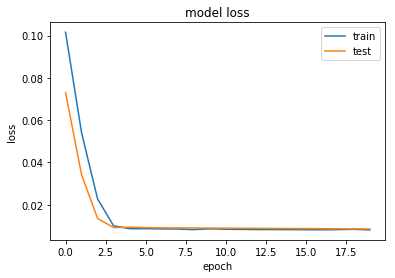

Test RMSE: 481.304


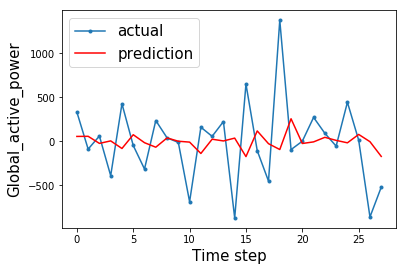

In [78]:
# Using 60% of data for training, 40% for validation.
values = reframed.values

n_train_time = 1112 - 28
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 1))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

aa=[x for x in range(28)]
plt.plot(aa, inv_y[:28], marker='.', label="actual")
plt.plot(aa, inv_yhat[:28], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

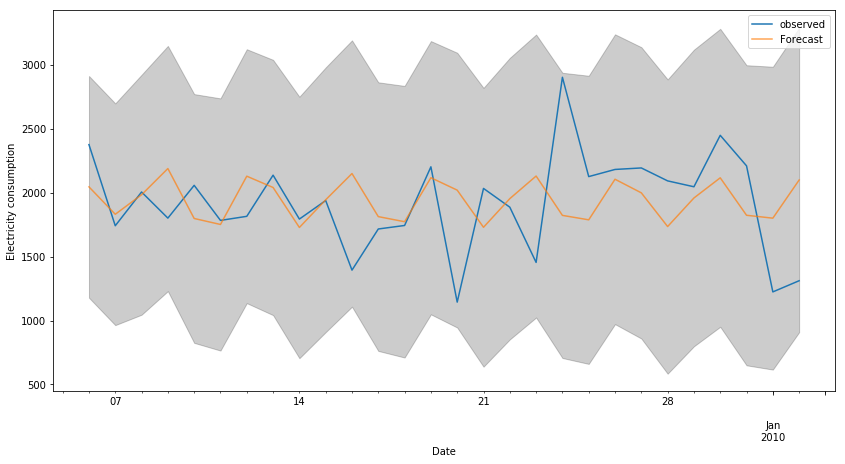

RMSE:424.63430070779845


In [79]:
start_date = '2009-12-06'
end_date = '2010-01-02'

pred = results.get_prediction(start = start_date, end = end_date, dynamic=1)
pred_ci = pred.conf_int()

ax = dailyGAP[start_date:end_date].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))

temp = []
for i in range(len(test_predict)):
    temp.append(test_predict[i,0])
test_predict = temp

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Electricity consumption')
plt.legend()

plt.show()

rmse = sqrt(mean_squared_error(pred.predicted_mean+inv_yhat, dailyGAP[start_date:end_date].values))
print('RMSE:{}'.format(rmse))

(1113, 1)


[88.27061, 86.25236, 86.14932, 89.615074, 88.931046, 89.27896, 84.71051, 89.48318, 89.57473, 87.36313, 89.05923, 89.336685, 86.820625, 88.1415, 88.95339, 87.49223, 84.29339, 80.27334, 89.657906, 88.937874, 55.563984, 89.62935, 89.27058, 86.94383, 88.71535, 89.508316, 84.42157, 89.21037]
